1. Сколько у нас пользователей, которые совершили покупку только один раз?

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

3. По каждому товару определить, в какой день недели товар чаще всего покупается.

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. 

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти [тут](https://vc.ru/s/productstar/134090-chto-takoe-kogortnyy-analiz).

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти [тут](https://guillaume-martin.github.io/rfm-segmentation-with-python.html).

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from urllib.parse import urlencode
import statistics
from collections import Counter
import datetime
import seaborn as sns
import math
pd.options.mode.chained_assignment = None

%matplotlib inline

In [161]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

olist_customers_dataset_url = 'https://disk.yandex.ru/d/L2cwpLgsSxvlxg'
olist_orders_dataset_url = 'https://disk.yandex.ru/d/_ZtcY9Exzs6ReQ'
olist_order_items_dataset_url = 'https://disk.yandex.ru/d/r1t7Ow-bl_E5VQ'

In [162]:
olist_customers_dataset_final_url = base_url + urlencode(dict(public_key=olist_customers_dataset_url)) 
response = requests.get(olist_customers_dataset_final_url) 
download_url = response.json()['href']

download_response = requests.get(download_url) 
olist_customers_database = pd.read_csv(download_url) 

In [163]:
# Таблица с инф. о пользователях
olist_customers_database.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [164]:
olist_customers_database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [165]:
olist_customers_database.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

Кажется, с таблицей, в которой хранится информация о покупателях, все хорошо. Пропусков нет, неуникальные id покупателей не повторяются.

In [166]:
olist_orders_final_url = base_url + urlencode(dict(public_key=olist_orders_dataset_url)) 
response = requests.get(olist_orders_final_url) 
download_url = response.json()['href']

download_response = requests.get(download_url) 
olist_orders_database = pd.read_csv(download_url) 

In [167]:
# Таблица с инф. о статусе заказов
olist_orders_database.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


In [168]:
olist_orders_database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [169]:
olist_orders_database.order_id.nunique()

99441

В таблице с информацией о статусе заказов есть несколько колонок с пропусками, id заказов не повторяются и на этом спасибо.

In [170]:
olist_order_items_final_url = base_url + urlencode(dict(public_key=olist_order_items_dataset_url)) 
response = requests.get(olist_order_items_final_url) 
download_url = response.json()['href']

download_response = requests.get(download_url) 
olist_order_items_database = pd.read_csv(download_url) 

In [171]:
# Таблица с инф. о заказах
olist_order_items_database.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [172]:
olist_order_items_database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [173]:
olist_order_items_database.order_id.nunique() - olist_orders_database.order_id.nunique()

-775

В таблице с информацией о заказах отсутствуют 775 заказов.

### 1) Сколько у нас пользователей, которые совершили покупку только один раз?

Для начала нужно определить, что можно считать покупкой.  

Интересен статус invoiced, который означает выставленный счет.

In [174]:
olist_orders_database.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [175]:
olist_orders_database.query('order_status == "invoiced"').head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaN,NaN,2017-05-09 00:00:00
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaN,NaN,2018-08-21 00:00:00
455,38b7efdf33dd5561f4f5d4f6e07b0414,021e84751ba0ead75b6d314a6ead88d9,invoiced,2017-08-01 18:17:41,2017-08-01 18:32:30,NaN,NaN,2017-08-28 00:00:00


In [176]:
olist_orders_database.query('order_status == "invoiced"').shape[0]

314

In [177]:
olist_orders_database.query('order_status == "invoiced"').order_approved_at.notna().sum()

314

In [178]:
olist_orders_database.query('order_status == "invoiced"').order_delivered_carrier_date.isna().sum()

314

Всего таких заказов 314. У них у всех есть подтверждения и ни у одного нет даты отправки.  

Посмотрим на заказы, с датой отправки.

In [179]:
olist_orders_database.query('order_delivered_carrier_date.notna()').order_status.value_counts()

delivered    96476
shipped       1107
canceled        75
Name: order_status, dtype: int64

У заказов с датой отправки видим всего несколько статусов: доставлен, отправлен, отменен.
Из этих заказов и будем отбирать покупки, т.к. судя по всему покупатели оплатили счет и только после этого была совершена отправка.  

Избавимся от отмененных и оставим только заказы со статусами delivered(доставлен)/shipped(отправлен).

In [180]:
purchases = olist_orders_database.query('order_delivered_carrier_date.notna() and order_status != "canceled"')

In [181]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97583 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       97583 non-null  object
 1   customer_id                    97583 non-null  object
 2   order_status                   97583 non-null  object
 3   order_purchase_timestamp       97583 non-null  object
 4   order_approved_at              97569 non-null  object
 5   order_delivered_carrier_date   97583 non-null  object
 6   order_delivered_customer_date  96469 non-null  object
 7   order_estimated_delivery_date  97583 non-null  object
dtypes: object(8)
memory usage: 6.7+ MB


Кажется, что у нас есть несколько заказов без подтверждения, но с датой отгрузки, а также заказы без даты доставки. Нужно избавиться от всех заказов без подтверждения и проверить все ли из заказов без даты доставки сейчас в пути. Если нет, то от них тоже избавимся.

In [182]:
purchases = purchases.query('order_approved_at.notna()')

In [183]:
purchases = purchases.query('order_delivered_customer_date.notna() or order_status == "shipped"')

Добавим в таблицу с покупками уникальный id пользователя, чтобы посмотреть кол-во покупок для каждого покупателя.

In [184]:
purchases = purchases.merge(olist_customers_database[['customer_id', 'customer_unique_id']], how='left', on='customer_id')

In [185]:
mv_col = purchases.pop('customer_unique_id')
purchases.insert(2, 'customer_unique_id', mv_col)

In [186]:
purchases.head(3)

,order_id,customer_id,customer_unique_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


Теперь можно посчитать кол-во пользователей, которые совершили 1 покупку.

In [187]:
purchases.groupby('customer_unique_id', as_index=False) \
    .agg({'order_id':'count'}) \
    .order_id.value_counts() \
    .head(1)

1    91517
Name: order_id, dtype: int64

### 2) Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)

Для начала возьмем из таблицы с заказами все статусы и дату предполагаемой доставки.

In [188]:
reasons_for_non_delivery = olist_orders_database[['order_status', 
                                                  'order_estimated_delivery_date']].query('order_status != "delivered"')

In [189]:
reasons_for_non_delivery.head(3)

,order_status,order_estimated_delivery_date
6,invoiced,2017-05-09 00:00:00
44,shipped,2018-06-28 00:00:00
103,invoiced,2018-08-21 00:00:00


Максимальную дату, когда был доставлен товар, будем считать за текущую. Эта дата будет хоть какой-то границей для того, чтобы сказать, просрочен заказ или нет.

In [190]:
max_date = pd.to_datetime(olist_orders_database.order_delivered_customer_date).max()

In [191]:
max_date

Timestamp('2018-10-17 13:22:46')

In [192]:
reasons_for_non_delivery.order_estimated_delivery_date = pd.to_datetime(reasons_for_non_delivery.order_estimated_delivery_date)

In [193]:
reasons_for_non_delivery.head(3)

,order_status,order_estimated_delivery_date
6,invoiced,2017-05-09
44,shipped,2018-06-28
103,invoiced,2018-08-21


In [194]:
reasons_for_non_delivery.query('order_estimated_delivery_date > @max_date')

,order_status,order_estimated_delivery_date
37003,canceled,2018-10-25
60938,canceled,2018-10-30
68373,canceled,2018-11-12
88500,canceled,2018-10-23


In [195]:
reasons_for_non_delivery = reasons_for_non_delivery.query('order_estimated_delivery_date < @max_date')

Если и есть заказы, у которых дата предполагаемой доставки больше "текущей", то они в любом случае отменены.  

Посмотрим на кол-во недоставленных заказов с разбиением по причинам.

In [197]:
reasons_for_non_delivery.groupby('order_status', as_index=False) \
    .agg({'order_estimated_delivery_date':'count'})

,order_status,order_estimated_delivery_date
0,approved,2
1,canceled,621
2,created,5
3,invoiced,314
4,processing,301
5,shipped,1107
6,unavailable,609


Добавим колонку с месяцем, когда не был доставлен заказ.

In [198]:
reasons_for_non_delivery['month'] = reasons_for_non_delivery.order_estimated_delivery_date.astype('datetime64[M]')

In [199]:
reasons_for_non_delivery.head()

,order_status,order_estimated_delivery_date,month
6,invoiced,2017-05-09,2017-05-01
44,shipped,2018-06-28,2018-06-01
103,invoiced,2018-08-21,2018-08-01
128,processing,2017-10-03,2017-10-01
154,shipped,2018-02-07,2018-02-01


Просуммируем по месяцам и причинам недоставленные заказы.

In [200]:
reasons_for_non_delivery = reasons_for_non_delivery.groupby(['month', 'order_status'], as_index=False) \
    .agg({'order_estimated_delivery_date': 'count'}) \
    .rename(columns={'order_estimated_delivery_date':'cnt'})

In [201]:
reasons_for_non_delivery.head(3)

,month,order_status,cnt
0,2016-09-01,canceled,1
1,2016-10-01,canceled,3
2,2016-10-01,shipped,1


Переведем все в пивот и отсортируем по месяцам.

In [203]:
reasons_for_non_delivery_pivot = reasons_for_non_delivery.pivot(index='month',
                                                                columns='order_status',
                                                                values='cnt') \
                                                                .fillna(0) \
                                                                .reset_index()

In [204]:
reasons_for_non_delivery_pivot = reasons_for_non_delivery_pivot.sort_values('month')

In [205]:
reasons_for_non_delivery_pivot

order_status,month,approved,canceled,created,invoiced,processing,shipped,unavailable
0,2016-09-01,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2016-10-01,0.0,3.0,0.0,0.0,0.0,1.0,0.0
2,2016-11-01,0.0,14.0,0.0,9.0,0.0,1.0,5.0
3,2016-12-01,0.0,8.0,0.0,9.0,2.0,7.0,2.0
4,2017-02-01,0.0,2.0,0.0,1.0,1.0,6.0,2.0
5,2017-03-01,1.0,26.0,0.0,21.0,38.0,41.0,66.0
6,2017-04-01,0.0,22.0,0.0,5.0,23.0,35.0,19.0
7,2017-05-01,1.0,23.0,0.0,19.0,12.0,60.0,16.0
8,2017-06-01,0.0,29.0,0.0,11.0,22.0,52.0,29.0
9,2017-07-01,0.0,21.0,0.0,10.0,13.0,51.0,34.0


In [47]:
reasons_for_non_delivery_pivot.iloc[:, 1:].mean()

order_status
approved        0.076923
canceled       24.038462
created         0.192308
invoiced       12.076923
processing     11.576923
shipped        42.576923
unavailable    23.423077
dtype: float64

In [48]:
reasons_for_non_delivery.groupby('month').cnt.sum()

month
2016-09-01      1
2016-10-01      4
2016-11-01     29
2016-12-01     28
2017-02-01     12
2017-03-01    193
2017-04-01    104
2017-05-01    131
2017-06-01    143
2017-07-01    129
2017-08-01    144
2017-09-01    148
2017-10-01    133
2017-11-01    174
2017-12-01    239
2018-01-01    142
2018-02-01    175
2018-03-01    223
2018-04-01    188
2018-05-01    168
2018-06-01     83
2018-07-01     87
2018-08-01    219
2018-09-01     53
2018-10-01     12
2018-11-01      1
Name: cnt, dtype: int64

Можно убрать первые и последние 2 месяца, которые практически пусты. Не будем считать медиану, потому что большие значения особо не будут отличаться, но при этом нельзя будет увидеть, что у нас не доставляются заказы про причинам 'approved', 'created'.

In [49]:
reasons_for_non_delivery_pivot.iloc[2:24, 1:].mean()

order_status
approved        0.090909
canceled       27.636364
created         0.227273
invoiced       14.272727
processing     13.681818
shipped        50.272727
unavailable    27.681818
dtype: float64

В итоге имеем такие средние показатели.

### 3) По каждому товару определить, в какой день недели товар чаще всего покупается


Возвращаемся к табличке с покупками. Создадим колонку с днем недели где 0 - пн и 6 - вс.

In [209]:
purchases['purchase_dayofweek'] = pd.to_datetime(purchases.order_purchase_timestamp).dt.dayofweek

In [211]:
mv_col = purchases.pop('purchase_dayofweek')
purchases.insert(4, 'purchase_dayofweek', mv_col)

In [212]:
purchases.head(3)

,order_id,customer_id,customer_unique_id,order_status,purchase_dayofweek,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,delivered,0,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,delivered,1,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,delivered,2,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


Возьмем только id заказа и день недели.

In [213]:
order_dayofweek = purchases[['order_id', 'purchase_dayofweek']]

In [214]:
order_dayofweek.head(3)

,order_id,purchase_dayofweek
0,e481f51cbdc54678b7cc49136f2d6af7,0
1,53cdb2fc8bc7dce0b6741e2150273451,1
2,47770eb9100c2d0c44946d9cf07ec65d,2


Добавим id товаров, которые есть в заказах. Помним, что не все заказы есть в таблице с данными о заказах, поэтому делаем иннер джоин.

In [216]:
order_dayofweek = order_dayofweek.merge(olist_order_items_database[['order_id', 'product_id']], on='order_id', how='inner')

In [217]:
order_dayofweek.head(3)

,order_id,purchase_dayofweek,product_id
0,e481f51cbdc54678b7cc49136f2d6af7,0,87285b34884572647811a353c7ac498a
1,53cdb2fc8bc7dce0b6741e2150273451,1,595fac2a385ac33a80bd5114aec74eb8
2,47770eb9100c2d0c44946d9cf07ec65d,2,aa4383b373c6aca5d8797843e5594415


In [218]:
order_dayofweek.shape

(111358, 3)

Теперь возьмем товары и сделаем колонку со списком всех дней, когда покупался данный товар.

In [220]:
product_mode_dayofweek = order_dayofweek.groupby('product_id', as_index=False) \
    .agg({'purchase_dayofweek': list})

In [222]:
product_mode_dayofweek.tail()

,product_id,purchase_dayofweek
32419,fff6177642830a9a94a0f2cba5e476d1,"[6, 5]"
32420,fff81cc3158d2725c0655ab9ba0f712c,[0]
32421,fff9553ac224cec9d15d49f5a263411f,[4]
32422,fffdb2d0ec8d6a61f0a0a0db3f25b441,"[4, 3, 1, 1, 6]"
32423,fffe9eeff12fcbd74a2f2b007dde0c58,[2]


У товара может быть больше, 1 моды.  
statistics multimode отказывается работать, потому что версия питона на сервере меньше 3.8 поэтому буду использовать это

In [223]:
def multimode(lst):
    
    '''Функция для расчета моды/мультимоды
    
    Аргументы:
    lst - список дней, в которые покупался товар
    
    Возвращает:
    список с днем/днями, когда товар чаще всего покупают
    
    '''
    res  = [] 
    lst1 = Counter(lst)
    temp = lst1.most_common(1)[0][1]
    for ele in lst:
          if lst.count(ele) == temp:
                res.append(ele)
    return list(set(res))

Применим функцию на список дней каждого товара и получим моду.

In [226]:
product_mode_dayofweek.purchase_dayofweek = product_mode_dayofweek.purchase_dayofweek.apply(lambda x: multimode(x))

In [228]:
product_mode_dayofweek.tail()

,product_id,purchase_dayofweek
32419,fff6177642830a9a94a0f2cba5e476d1,"[5, 6]"
32420,fff81cc3158d2725c0655ab9ba0f712c,[0]
32421,fff9553ac224cec9d15d49f5a263411f,[4]
32422,fffdb2d0ec8d6a61f0a0a0db3f25b441,[1]
32423,fffe9eeff12fcbd74a2f2b007dde0c58,[2]


### 4) Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

Разбитую неделю буду относить к определенному месяцу смотря на последний день недели. Если воскресенье относится к след. месяцу, то и всю неделю я буду относить к этому месяцу. Я не хочу дробить неделю на части, потому что средние значения могут отклоняться очень сильно из-за различных особенностей.

Возьмем уникальные id пользователей и дату покупки.

In [229]:
customer_weekmonth_revenue = purchases[['customer_unique_id', 'order_purchase_timestamp']]

In [230]:
customer_weekmonth_revenue.head(3)

,customer_unique_id,order_purchase_timestamp
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49


In [231]:
customer_weekmonth_revenue['order_purchase_timestamp'] = pd.to_datetime(customer_weekmonth_revenue['order_purchase_timestamp'])

In [232]:
customer_weekmonth_revenue['year'] = customer_weekmonth_revenue['order_purchase_timestamp'].dt.year
customer_weekmonth_revenue['month'] = customer_weekmonth_revenue['order_purchase_timestamp'].dt.month
customer_weekmonth_revenue['week_num'] = customer_weekmonth_revenue['order_purchase_timestamp'].dt.isocalendar().week

In [233]:
customer_weekmonth_revenue.head()

,customer_unique_id,order_purchase_timestamp,year,month,week_num
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017,10,40
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,2018,7,30
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,2018,8,32
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,2017,11,46
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,2018,2,7


Добавим колонку с датой последнего дня недели.

In [234]:
customer_weekmonth_revenue['sunday'] = pd.to_datetime(customer_weekmonth_revenue.week_num.astype(str) \
    + customer_weekmonth_revenue.year.astype(str).add('-7'), format='%V%G-%u')

In [235]:
customer_weekmonth_revenue.head(3)

,customer_unique_id,order_purchase_timestamp,year,month,week_num,sunday
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017,10,40,2017-10-08
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,2018,7,30,2018-07-29
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,2018,8,32,2018-08-12


In [236]:
customer_weekmonth_revenue.year = customer_weekmonth_revenue.sunday.dt.year
customer_weekmonth_revenue.month = customer_weekmonth_revenue.sunday.dt.month
customer_weekmonth_revenue.week_num = customer_weekmonth_revenue.sunday.dt.isocalendar().week

Считаем кол-во покупок за неделю.

In [238]:
customer_weekmonth_revenue = customer_weekmonth_revenue.groupby(['customer_unique_id', 'year',
                                                                 'month', 'week_num'],as_index=False) \
                                                        .agg({'order_purchase_timestamp':'count'}) \
                                                        .rename(columns={'order_purchase_timestamp':'purchases_in_week'})

In [240]:
customer_weekmonth_revenue.head()

,customer_unique_id,year,month,week_num,purchases_in_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018,5,19,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018,5,19,1
2,0000f46a3911fa3c0805444483337064,2017,3,10,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017,10,41,1
4,0004aac84e0df4da2b147fca70cf8255,2017,11,46,1


In [241]:
customer_weekmonth_revenue.purchases_in_week.mean()

1.0106805067802054

In [244]:
customer_weekmonth_revenue.shape[0]

96531

In [247]:
customer_weekmonth_revenue.customer_unique_id.nunique()

94377

В целом грустные результаты. Почти все клиенты совершают всего 1 покупку за все время.

### 5) Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

In [77]:
purchases.head(3)

,order_id,customer_id,customer_unique_id,order_status,purchase_dayofweek,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,delivered,0,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,delivered,1,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,delivered,2,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


In [78]:
order_date = purchases[['customer_unique_id', 'order_purchase_timestamp']] \
                        .rename(columns={'order_purchase_timestamp':'purchase_month'})

In [79]:
# Сразу приведем дату покупки к месяцам
order_date['purchase_month'] = order_date['purchase_month'].to_numpy().astype('datetime64[M]')

In [80]:
order_date.head(3)

,customer_unique_id,purchase_month
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-01
1,af07308b275d755c9edb36a90c618231,2018-07-01
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-01


In [81]:
# Таблица с первым заказом покупателей
first_purchase = order_date.groupby('customer_unique_id', as_index=False) \
    .agg({'purchase_month': 'min'}) \
    .rename(columns={'purchase_month':'first_month'})

In [82]:
first_purchase.head(3)

,customer_unique_id,first_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01
2,0000f46a3911fa3c0805444483337064,2017-03-01


In [83]:
# Добавил к основной таблице дату первой покупки пользователя
order_date = order_date.merge(first_purchase, on='customer_unique_id', how='left')

In [84]:
order_date.head(3)

,customer_unique_id,purchase_month,first_month
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-01,2017-09-01
1,af07308b275d755c9edb36a90c618231,2018-07-01,2018-07-01
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-01,2018-08-01


In [85]:
order_date.first_month.min()

Timestamp('2016-09-01 00:00:00')

In [86]:
order_date.first_month.max()

Timestamp('2018-08-01 00:00:00')

Нас интересуют только когорты с 2017-01-01 по 2017-12-01. От остальных можем избавиться.

In [87]:
# Границы для когорт
min_date = pd.to_datetime("2017-01-01")
max_date = pd.to_datetime("2017-12-01")
# Граница для просмотра ретеншена на 3 месяц
max_date_for_retention = pd.to_datetime("2018-03-01")

In [88]:
order_date = order_date.query('first_month >= @min_date and first_month <= @max_date')

In [89]:
# Задем рейндж для ретеншена
months = pd.DataFrame(pd.date_range(min_date, max_date_for_retention, freq='MS'))

In [90]:
months.columns = ['month']

In [91]:
# Ключ для мерджа
order_date['key'] = 1
months['key'] = 1

In [92]:
# Накидываем на каждого пользователя рейндж(все месяцы)
order_date = order_date.merge(months, on='key')[['customer_unique_id', 'purchase_month', 'first_month', 'month']]

In [93]:
order_date.head(3)

,customer_unique_id,purchase_month,first_month,month
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-01,2017-09-01,2017-01-01
1,7c396fd4830fd04220f754e42b4e5bff,2017-10-01,2017-09-01,2017-02-01
2,7c396fd4830fd04220f754e42b4e5bff,2017-10-01,2017-09-01,2017-03-01


In [94]:
# Отсекаем лишние значения
order_date = order_date.query('month >= first_month')

In [95]:
# Смотрим, если совпадают значения, значит была совершена покупка
order_date['purchase_month'] = (order_date['purchase_month'] == order_date['month']) * 1.0

In [96]:
order_date.shape[0]

360354

In [97]:
# Таблица, в которой по каждому пользователю показаны покупки за все время от первой покупки до последнего месяца
order_date = order_date.groupby(['customer_unique_id', 'first_month', 'month'], as_index=False) \
                            .agg({'purchase_month':'max'})

In [98]:
order_date

,customer_unique_id,first_month,month,purchase_month
0,0000f46a3911fa3c0805444483337064,2017-03-01,2017-03-01,1.0
1,0000f46a3911fa3c0805444483337064,2017-03-01,2017-04-01,0.0
2,0000f46a3911fa3c0805444483337064,2017-03-01,2017-05-01,0.0
3,0000f46a3911fa3c0805444483337064,2017-03-01,2017-06-01,0.0
4,0000f46a3911fa3c0805444483337064,2017-03-01,2017-07-01,0.0
...,...,...,...,...
342509,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2017-11-01,0.0
342510,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2017-12-01,0.0
342511,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2018-01-01,0.0
342512,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2018-02-01,0.0


In [99]:
# Итоговая таблица ретеншена
retention_table = order_date.pivot_table(index='first_month', columns='month', values='purchase_month', aggfunc='mean')

In [100]:
retention_table

month,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01
first_month,,,,,,,,,,,,,,,
2017-01-01,1.0,0.004115,0.002743,0.001372,0.004115,0.001372,0.004115,0.001372,0.001372,0.000000,0.004115,0.001372,0.006859,0.004115,0.001372
2017-02-01,NaN,1.000000,0.002445,0.003056,0.001222,0.004279,0.001222,0.002445,0.001834,0.000611,0.001834,0.001222,0.003056,0.001222,0.001834
2017-03-01,NaN,NaN,1.000000,0.005108,0.003536,0.003929,0.003536,0.001572,0.001572,0.003143,0.003143,0.000786,0.003536,0.001179,0.001965
2017-04-01,NaN,NaN,NaN,1.000000,0.006087,0.002174,0.001739,0.003043,0.002609,0.003478,0.003043,0.003043,0.001739,0.002609,0.000870
2017-05-01,NaN,NaN,NaN,NaN,1.000000,0.004853,0.004853,0.003711,0.003140,0.003426,0.004282,0.001427,0.002569,0.002569,0.002569
2017-06-01,NaN,NaN,NaN,NaN,NaN,1.000000,0.004543,0.003569,0.003894,0.002596,0.003569,0.003569,0.002271,0.001298,0.002271
2017-07-01,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.005255,0.003416,0.002365,0.002890,0.002102,0.003153,0.001051,0.001839
2017-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.006838,0.003419,0.002686,0.003419,0.005372,0.002930,0.002686
2017-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.006936,0.005450,0.002973,0.004459,0.002229,0.002229


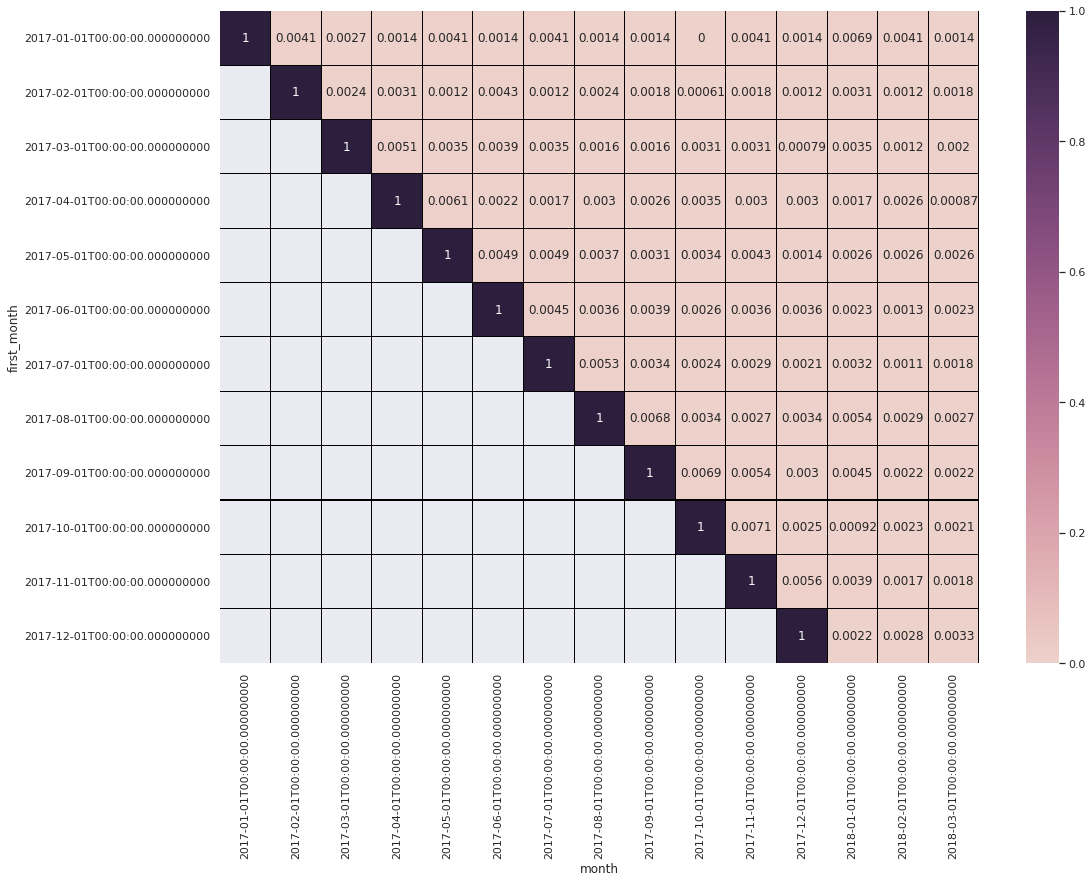

In [101]:
sns.set(font_scale=1,rc={'figure.figsize':(17,12)} )
sns.heatmap(retention_table, cmap=sns.cubehelix_palette(as_cmap=True),
            annot=True, linecolor='black', linewidths=0.1)

In [102]:
# Чтобы понять у какой когорты лучший ретеншен возьмем 3 месяц от каждой когорты
order_date['lifetime'] = ((order_date['month'] - order_date['first_month'])/np.timedelta64(1, 'M')).round().astype(int)

In [103]:
order_date.head(4)

,customer_unique_id,first_month,month,purchase_month,lifetime
0,0000f46a3911fa3c0805444483337064,2017-03-01,2017-03-01,1.0,0
1,0000f46a3911fa3c0805444483337064,2017-03-01,2017-04-01,0.0,1
2,0000f46a3911fa3c0805444483337064,2017-03-01,2017-05-01,0.0,2
3,0000f46a3911fa3c0805444483337064,2017-03-01,2017-06-01,0.0,3


In [104]:
# Когорта с топ ретеншеном 3 месяца -> 2017-03-01
cohorts = order_date.query('lifetime == 3') \
    .groupby('first_month', as_index=False) \
    .agg({'purchase_month':'mean'}) \
    .sort_values(by='purchase_month', ascending=False)

cohorts.head()

,first_month,purchase_month
2,2017-03-01,0.003929
5,2017-06-01,0.003894
4,2017-05-01,0.003711
11,2017-12-01,0.003340
8,2017-09-01,0.002973


### 6) RFM

R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время

In [105]:
orders = purchases[['order_purchase_timestamp', 'order_id', 'customer_unique_id']] \
            .rename(columns={'order_purchase_timestamp':'purchase'})

In [106]:
orders['purchase'] = pd.to_datetime(orders['purchase']).dt.normalize()

In [107]:
orders.head(3)

,purchase,order_id,customer_unique_id
0,2017-10-02,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff
1,2018-07-24,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231
2,2018-08-08,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8


In [108]:
orders['purchase_month'] = orders['purchase'].astype('datetime64[M]')

In [109]:
# Таблица с суммой заказа
monetary = olist_order_items_database.groupby('order_id', as_index=False) \
    .agg({'price':'sum'}) \
    .rename(columns={'price':'monetary'})

In [110]:
monetary.head(1)

,order_id,monetary
0,00010242fe8c5a6d1ba2dd792cb16214,58.9


In [111]:
orders.head(1)

,purchase,order_id,customer_unique_id,purchase_month
0,2017-10-02,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-01


In [112]:
orders = orders.merge(monetary, on='order_id', how='inner')

In [113]:
orders.head(3)

,purchase,order_id,customer_unique_id,purchase_month,monetary
0,2017-10-02,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-01,29.99
1,2018-07-24,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,2018-07-01,118.70
2,2018-08-08,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-01,159.90


In [114]:
# Последняя покупка каждого клиента
last_purchase = orders.groupby('customer_unique_id', as_index=False) \
                        .purchase.max() \
                        .rename(columns={'purchase': 'last_purchase'})

In [115]:
last_purchase.head(3)

,customer_unique_id,last_purchase
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07
2,0000f46a3911fa3c0805444483337064,2017-03-10


In [116]:
# Кол-во покупок по каждому клиенту
frequency = orders.groupby('customer_unique_id', as_index=False) \
                        .agg({'order_id': 'count'}) \
                        .rename(columns={'order_id':'frequency'})

In [117]:
rfm_data = orders.merge(last_purchase, on='customer_unique_id', how='left')

In [118]:
rfm_data = rfm_data.merge(frequency, on='customer_unique_id', how='left') \
                    [['customer_unique_id', 'last_purchase', 'frequency', 'monetary']]

In [119]:
rfm_data.head(3)

,customer_unique_id,last_purchase,frequency,monetary
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02,2,29.99
1,af07308b275d755c9edb36a90c618231,2018-07-24,1,118.70
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08,1,159.90


In [120]:
rfm_data['edge'] = rfm_data.last_purchase.max()

In [121]:
rfm_data['last_purchase'] = rfm_data['edge'] - rfm_data['last_purchase']

In [122]:
rfm_data = rfm_data.rename(columns={'last_purchase':'recency'})

In [123]:
rfm_data.head(3)

,customer_unique_id,recency,frequency,monetary,edge
0,7c396fd4830fd04220f754e42b4e5bff,336 days,2,29.99,2018-09-03
1,af07308b275d755c9edb36a90c618231,41 days,1,118.70,2018-09-03
2,3a653a41f6f9fc3d2a113cf8398680e8,26 days,1,159.90,2018-09-03


In [124]:
rfm_data = rfm_data.drop('edge', axis=1)

In [125]:
# Теперь у нас есть таблица со всеми необходимыми данными
# recency - дата последней покупки
# frequency - кол-во покупок
# monetary - сумма потраченая покупателем
rfm_data.head(3)

,customer_unique_id,recency,frequency,monetary
0,7c396fd4830fd04220f754e42b4e5bff,336 days,2,29.99
1,af07308b275d755c9edb36a90c618231,41 days,1,118.70
2,3a653a41f6f9fc3d2a113cf8398680e8,26 days,1,159.90


In [126]:
rfm_data['recency'] = rfm_data.recency.dt.days

In [127]:
rfm_data.head(3)

,customer_unique_id,recency,frequency,monetary
0,7c396fd4830fd04220f754e42b4e5bff,336,2,29.99
1,af07308b275d755c9edb36a90c618231,41,1,118.70
2,3a653a41f6f9fc3d2a113cf8398680e8,26,1,159.90


In [128]:
# Находим r
# Так как меньшее кол-во дней лучше, нужно перевернуть значения для r
rfm_data['r'] = 4 - (pd.qcut(rfm_data['recency'], 4, labels=False))

In [129]:
rfm_data.head(3)

,customer_unique_id,recency,frequency,monetary,r
0,7c396fd4830fd04220f754e42b4e5bff,336,2,29.99,2
1,af07308b275d755c9edb36a90c618231,41,1,118.70,4
2,3a653a41f6f9fc3d2a113cf8398680e8,26,1,159.90,4


In [130]:
# Тут qcut справился без проблем и поделил на 4 почти равные части 
rfm_data.groupby('r', as_index=False) \
    .agg({'recency': 'count'})

,r,recency
0,1,24347
1,2,24250
2,3,24303
3,4,24661


In [131]:
rfm_data['frequency'].value_counts()

1     91516
2      5256
3       552
4       116
5        45
6        30
7        21
16       16
9         9
Name: frequency, dtype: int64

In [132]:
# Размечу руками потому что qcut не справляется из-за большого кол-ва единиц
def hand_f(x):
    if x == 1:
        return 1
    if x == 2:
        return 2
    if x in [3,4]:
        return 3
    return 4

In [133]:
rfm_data['f'] = rfm_data['frequency'].apply(hand_f)

In [134]:
rfm_data.head(3)

,customer_unique_id,recency,frequency,monetary,r,f
0,7c396fd4830fd04220f754e42b4e5bff,336,2,29.99,2,2
1,af07308b275d755c9edb36a90c618231,41,1,118.70,4,1
2,3a653a41f6f9fc3d2a113cf8398680e8,26,1,159.90,4,1


In [135]:
rfm_data.groupby('f', as_index=False) \
    .agg({'frequency': 'count'})

,f,frequency
0,1,91516
1,2,5256
2,3,668
3,4,121


In [136]:
# С суммой не должно быть проблем, считаем qcut'ом
rfm_data['m'] = pd.qcut(rfm_data['monetary'], 4, labels=False) + 1

In [137]:
rfm_data.groupby('m', as_index=False) \
    .agg({'monetary': ['mean','count']})

m    monetary       
            mean  count
0  1   28.598207  24517
1  2   63.805712  24265
2  3  114.896118  24609
3  4  343.080700  24170

In [138]:
rfm_data['segment'] = rfm_data.r.astype(str) + rfm_data.f.astype(str) + rfm_data.m.astype(str)

In [139]:
# Итоговая таблица
rfm_data.head()

,customer_unique_id,recency,frequency,monetary,r,f,m,segment
0,7c396fd4830fd04220f754e42b4e5bff,336,2,29.99,2,2,1,221
1,af07308b275d755c9edb36a90c618231,41,1,118.70,4,1,3,413
2,3a653a41f6f9fc3d2a113cf8398680e8,26,1,159.90,4,1,4,414
3,7c142cf63193a1473d2e66489a9ae977,289,1,45.00,2,1,1,211
4,72632f0f9dd73dfee390c9b22eb56dd6,202,1,19.90,3,1,1,311


Попробуем немного уменьшить кол-во сегментов, разделив их на группы.  
Всего пусть будет 8 групп:  
1. VIP - часто и постоянно покупают
2. Клиент - покупают не так часто или не так постоянно как vip'ы
3. Потенциальный клиент - несколько покупок, последняя недавно
4. Должны удержать - люди, которые по частоте покупок относятся к 2 лучшим группам, но они достаточно давно ничего не покупали
5. Должны вернуть - люди, которые по частоте покупок относятся к 2 лучшим группам, но они уже давно ничего не покупали
6. Уделить внимание - люди, которые совершили 1-2 покупки и некоторое время ничего не покупают
7. Потерян - люди, которые сделали 1-2 покупки и давно ничего не покупали 
8. Новые покупатели - люди, которые только совершили свою первую покупку

In [140]:
seg_map = {
    r'44': 'VIP',
    r'[3-4]3': 'Клиент',
    r'34': 'Клиент',
    r'42': 'Потенциальный',
    r'2[3-4]': 'Удержать',
    r'1[3-4]': 'Вернуть',
    r'3[1-2]': 'Внимание',
    r'22': 'Внимание',
    r'[1-2]1': 'Потерян',
    r'12': 'Потерян',
    r'41': 'Новый'
}

In [141]:
rfm_data['group'] = rfm_data['r'].map(str) + rfm_data['f'].map(str)

In [142]:
rfm_data['group'] = rfm_data['group'].replace(seg_map, regex=True)

In [143]:
rfm_data

,customer_unique_id,recency,frequency,monetary,r,f,m,segment,group
0,7c396fd4830fd04220f754e42b4e5bff,336,2,29.99,2,2,1,221,Внимание
1,af07308b275d755c9edb36a90c618231,41,1,118.70,4,1,3,413,Новый
2,3a653a41f6f9fc3d2a113cf8398680e8,26,1,159.90,4,1,4,414,Новый
3,7c142cf63193a1473d2e66489a9ae977,289,1,45.00,2,1,1,211,Потерян
4,72632f0f9dd73dfee390c9b22eb56dd6,202,1,19.90,3,1,1,311,Внимание
...,...,...,...,...,...,...,...,...,...
97556,6359f309b166b0196dbf7ad2ac62bb5a,543,1,72.00,1,1,2,112,Потерян
97557,da62f9e57a76d978d02ab5362c509660,209,1,174.90,3,1,4,314,Внимание
97558,737520a9aad80b3fbbdad19b66b37b30,372,1,205.99,1,1,4,114,Потерян
97559,5097a5312c8b157bb7be58ae360ef43c,238,1,359.98,2,1,4,214,Потерян


In [144]:
rfm_data.group.value_counts()

Потерян          47031
Внимание         25362
Новый            22917
Потенциальный     1462
Клиент             458
Вернуть            138
Удержать           136
VIP                 57
Name: group, dtype: int64

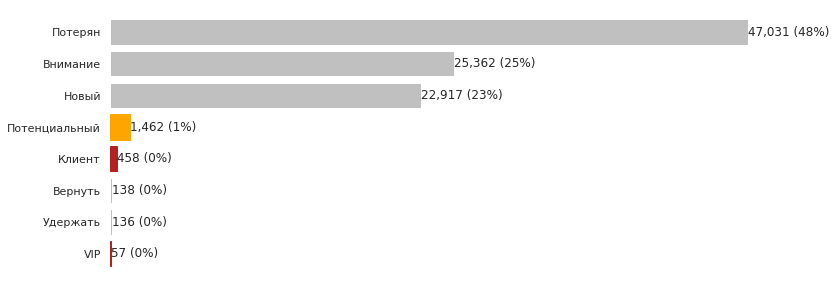

In [145]:
sns.set(font_scale=1,rc={'figure.figsize':(12,5)} )
segments_counts = rfm_data['group'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['VIP', 'Клиент']:
            bar.set_color('firebrick')
        if segments_counts.index[i] in ['Потенциальный']:
            bar.set_color('orange')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

In [146]:
revenue = rfm_data.groupby('group', as_index=False) \
        .agg({'monetary':'sum'}) \
        .sort_values(by='monetary', ascending=False)

In [147]:
revenue['monetary'] = revenue['monetary'].apply(lambda x: f"{x:.0f}")

In [148]:
revenue

,group,monetary
6,Потерян,6456689
2,Внимание,3418602
4,Новый,3213370
5,Потенциальный,182085
3,Клиент,59223
7,Удержать,21052
1,Вернуть,12066
0,VIP,6041


Нужно принимать меры для удержания и привлечения клиентов. Постоянных слишком мало, а потерянных слишком много(почти половина). Есть надежда на новых покупателей, а также покупателей, находящихся в зоне риска, которым нужно уделить внимание.
Все становится еще печальнее, если посмотреть на доход от пользователей. Хоть у нас и есть лояльные клиенты, но по сути они не приносят значимую прибыль. 